# Named Entity Evaluator Class

#next steps

- write tests for methods
- improve partial text matching method
    - any overlap
    - overlapping more than x characters
    - is an entity contained in the prediction

- improve spurious counting method
- fix spans mismatch

#design
- check if display needs to be moved to a separate class (w/ respect to single responsibility)
- check on the usage of side effects on class variables
- turn some methods and variables to private
- create getters for the metric dictionaries

#performance
- improve speed
    - profile method calls vs using self.variables

#explore
- weighted recall based on prevelance

Notes to explain:

- impact of TN on metrics chosen 
- impact of spurious on metrics chosen
- add visualizations
- what accounted for most spurious

In [273]:
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [13]:
d = open("./ner_finetune_model_results_20220414.json")


data = json.load(d)
results = json.loads(data)

original_df=pd.DataFrame(results).T
df=original_df

# Separate Fake and Real Documents
real_rows=[name for name in original_df.index if 'FAKE' not in name]
fake_rows=[name for name in original_df.index if 'FAKE' in name]

real_df=df.drop(index=fake_rows)
fake_df=df.drop(index=real_rows)


df=real_df

## Purpose:


    The purpose of this experiement is to explore the varouis approaches and considerations in the evaluation of Named Entity Recognition models.

## Challenges
    Major challenges faced included determining a threshold for counting partial entities, the nature of true negative samples in NER, determining false positive entities, and comparing the validity of alternative forms of calculating specific metrics.


    Base counts include:
    - text matches 
    - partial matches
    - exact matches
    - label matches
    - missed entities
    - missed entities with no predictions
    - label only matches
    - spurious entities (False Positive)
    - counts of the actual entity being found inside of a predicted entity during a partial match
    - counts of the predicted entity being found inside of an actual entity during a partial match
    
## Metrics
    The NER_Model_Evaluator is a class constructed to gain insight into the performance of NER tasks by counting relevant occurances in the text and leveraging those counts to produce various scores.

    The NER_Model_Evaluator currently provides a count of:
    - Documents with the most missed entities
    - Most frequently missed Entities
    - Most common Entities
    
    The NER_Model_Evaluator currently leverages counts to provide scores that include:
    - Recall
    - Recall considering partial matches
    - False Discovery Rate
    - False Negative Rate
    - Jaccard Index

In [253]:
class NER_Model_Evaluator:
   
    # init method or constructor 
    def __init__(self, eval_data):
        self.eval_data = eval_data
        
        self.original_df=pd.DataFrame(eval_data)
        self.metrics_list=["text_matches","records", "partial_text", "label_matches", "actNpred_text" , "predNact_text", "partial_span", "missed", "overlaps", "spurious", "spur_punc", "exact_match", "text_no_label", "pred_overlaps", "no_pred" ] #RC -extract to parameter
        
        self.most_common_entities={}
        self.most_common_missed_entities={}
        self.most_common_missed_docs={}
        self.entity_dict={}
        self.filenames_set={}
        self.metrics_dict={}
        self.missed_entity_dict={}
        self.missed_doc_dict={}
        self.missed_rates={}
        
        
        # Create Getters to retreive variables of interest
    
    
#-----------------------------------------BASIC_COUNTS 
    # count expected
    def count_expected(self, df):
        actual_expected_count=0
        for row in df.iterrows():    
            actual_expected_count+=len(row[1]['expected'])
        return actual_expected_count
    
    def count_predictions(self, df):
        predictions_count=0
        for row in df.iterrows():
            predictions_count+=len(row[1]['predicted'])
        return predictions_count
      
#-----------------------------------------   Matching    (True/False)
    def is_spurious(self, row):
        is_spur=True
        for predicted in row[1]['predicted']:
            predicted_range = range(predicted['span'][0], predicted['span'][1]+1)
            for actual_entity in row[1]['expected']:
                expected_range = range(actual_entity['span'][0], actual_entity['span'][1]+1)
                overlap = set(expected_range).intersection(predicted_range)
                in_text= predicted['text'] in (self.entity_dict.keys())
                if overlap or in_text:
                    is_spur=False
            #elif predicted['text'] in string.punctuation:
                #is_spur=True 
                #print(predicted['text'])

                #another function for returning spurious?
                #store spurious entities (to find a relationship with actual and spurious?)
                #print(f" \n Spurious entity: {predicted} \n Actual Entities: {row[1]['expected']}")
        return is_spur


    def is_exact_match(self,actual_entity, predicted):   #maybe remove
        if self.is_text_exact_match(actual_entity, predicted) and self.is_label_match(actual_entity, predicted):
            return True
        return False
    
    def is_text_exact_match(self,actual_entity, predicted):
        if predicted['text'].strip()==actual_entity['text'].strip():
            return True
        return False

    def is_label_match(self,actual_entity, predicted):
        if predicted['label'] == actual_entity['label']:
            return True
        return False

#-----------------------------------------   Metrics   

    ##-----------------------------------------   Pre dictionaries
    
        ##----------------------------------------- base for dictionaries
   

    
    def make_filenames_set(self,df):
        filename_set=set() #filenames
        for name in df.index:
            filename_set.add(name)
        return filename_set
            
    def make_gold_entity_dict(self,df):
        entity_dict=dict() #gold list entities
        entity_set=set() # replace usage with entity_dict.keys()

        for row_index, row in enumerate(df.iterrows()): 
            #print(f" Row {row[1]['expected']}")
            for actual_entity in row[1]['expected']: 
                entity_set.add(actual_entity['text'])
                if actual_entity['text'] in entity_dict.keys():
                    #entity_dict[actual_entity['text']]= entity_dict[actual_entity['text']]+1
                    entity_dict[actual_entity['text']]+= 1
                else:
                    entity_dict[actual_entity['text']]= 1
        return entity_dict
                    
                
    #------------------- Depends on pre dicts
    
    def init_missed_entity_dict(self,df):
        self.missed_entity_dict= dict.fromkeys(self.make_gold_entity_dict(df).keys(),0)
 
    def init_missed_doc_dict(self,df):
        self.missed_doc_dict= dict.fromkeys(self.make_filenames_set(df),0)
        
        #------------------- Depends on missed dictionaries
        
    def initialize(self,df):
        self.filenames_set=self.make_filenames_set(df)
        self.entity_dict=self.make_gold_entity_dict(df)
        self.init_missed_entity_dict(df)
        self.init_missed_doc_dict(df)
        self.build_metrics_dict(self.original_df)
        
        #print(self.missed_entity_dict)
        #print()
        #print()
        #print()

    def update_match_metrics(self,actual_entity, predicted, metrics_dict):
        label_match= self.is_label_match(actual_entity, predicted)
        updated_metrics_dict= metrics_dict
        if label_match:
            updated_metrics_dict['label_matches']+=1
        else:
            pass
            # Check if there is an exact match
        exact= self.is_text_exact_match(actual_entity, predicted)
        if exact:
            updated_metrics_dict['text_matches']+=1
            if label_match:
                updated_metrics_dict['exact_match']+=1
            else:
                updated_metrics_dict['text_no_label']+=1
        else:
            updated_metrics_dict['partial_text']+=1
        # check if the actual was in the prediction or of the predicted was in the actual
        if ((predicted['text'] in actual_entity['text']) or (actual_entity['text'] in predicted['text'])) and (predicted['text']!=actual_entity['text']):
            if (predicted['text'] in actual_entity['text']):
                updated_metrics_dict['predNact_text']+=1
            elif (actual_entity['text'] in predicted['text']):
                updated_metrics_dict['actNpred_text']+=1
        return updated_metrics_dict
 
    def build_metrics_dict(self,df):
        self.metrics_dict= dict.fromkeys(self.metrics_list,0)

    
    def process_row(self,row): #adds missed entities and docs
        for actual_entity in row[1]['expected']:

            max_overlap=0
            best_match_index=None
            expected_range = range(actual_entity['span'][0], actual_entity['span'][1]+1)
            for pred_index, predicted in enumerate(row[1]['predicted']):

                predicted_range = range(predicted['span'][0], predicted['span'][1]+1)
                overlap = set(expected_range).intersection(predicted_range)
                if len(overlap)>max_overlap:
                    max_overlap=len(overlap)
                    best_match_index=pred_index 
                    self.metrics_dict=self.update_match_metrics(actual_entity, predicted,self.metrics_dict)

            if best_match_index==None:
                self.metrics_dict['missed']+=1
                self.missed_doc_dict[f"{row[0]}"]+=1
                self.missed_entity_dict[actual_entity['text']]+=1
    
    ##-----------------------------------------   Post dictionaries    
    
    def make_most_common_entities(self,df):
        self.most_common_entities= dict(Counter(self.entity_dict).most_common(10))
           
    def make_most_common_missed_entities(self,df):
        self.most_common_missed_entities=dict(Counter(self.missed_entity_dict).most_common(10))
          
    def make_most_common_missed_docs(self,df):
        self.most_common_missed_docs=dict(Counter(self.missed_doc_dict).most_common(10))
        
        
    def initialize_most_common(self,df):
        self.make_most_common_entities(df)
        self.make_most_common_missed_entities(df)
        self.make_most_common_missed_docs(df)
        
    ##----------------------------------------- Calculations
    
    def calculate_missed_rates(self,missed_entity_dict): # False Negative Rate (FNR)        
        missed_rates= dict.fromkeys(self.most_common_missed_entities,0)
        #weighted_missed_rates= dict.fromkeys(most_common_missed_entities,0)   
        for key in missed_rates.keys():
            self.missed_rates[f"{key}"]= self.most_common_missed_entities[key]/self.entity_dict[key]  #divide by zero exception
            
    #def weighted_missed_rates     
        
    def calculate_false_discovery_rate(self,): #(FDR) 
        self.metrics_dict["false_discovery_rate"] = self.metrics_dict["spurious"]/ (self.metrics_dict["text_matches"]+self.metrics_dict["spurious"])

    def calculate_recall(self): # True Positive Rate
        self.metrics_dict["recall"] = self.metrics_dict["text_matches"]/(self.metrics_dict["missed"]+self.metrics_dict["text_matches"]) #entities got right/ (entities missed+entities_I_got_right)
        
    def calculate_recall_w_partial_matches(self):
        self.metrics_dict["partial_recall"] = (self.metrics_dict["text_matches"]+(0.5*self.metrics_dict["partial_text"]))/(self.metrics_dict["missed"]+self.metrics_dict["text_matches"])
        
    def calculate_jaccard_index(self):
        self.metrics_dict["jacaard"]= self.metrics_dict["text_matches"]/(self.metrics_dict["text_matches"]+self.metrics_dict["missed"]+self.metrics_dict["spurious"])
    
    
    def display_dict(self,dictionary):
        for x in dictionary:
            print(f" {x} : {dictionary[x]}")
    
    # display
    def display_evaluations(self):
        for x in self.metrics_dict:
            print(f" {x}: {self.metrics_dict[x]}")
            
        print(f"\n Most Common Missed Docs: \n")
        self.display_dict(self.most_common_missed_docs)
        print(f"\n Most Common Missed Entities: \n")
        self.display_dict(self.most_common_missed_entities)
        print(f"\n Most Common Entities:\n")    
        self.display_dict(self.most_common_entities)
        print(f"\n Entity Miss rates:\n") 
        self.display_dict(self.missed_rates)
                  
                  
                  
    # Driver of the class            
    def evaluate(self):
        # True positives = # text_matches
        # False Negatives = # missed
        # False Positive = sporadic
        # True Negative = N/A from results [need all of original text, or at least word count]
        
        self.initialize(df)
        
        #print(self.missed_entity_dict)
        
        #process rows and create base metrics dictionaries
        for row in df.iterrows():
            if self.is_spurious(row):
                self.metrics_dict['spurious']+=1
            self.process_row(row)
        # perform composite calculatons from base metrics
        self.initialize_most_common(df)
        
        self.calculate_recall()
        self.calculate_recall_w_partial_matches()
        self.calculate_false_discovery_rate()
        self.calculate_missed_rates(self.most_common_missed_entities)
        self.calculate_jaccard_index()
        
        # display calculations
        self.display_evaluations()

In [254]:
evaluator= NER_Model_Evaluator(df)

In [255]:
evaluator.evaluate()

 text_matches: 5369
 records: 0
 partial_text: 470
 label_matches: 5821
 actNpred_text: 266
 predNact_text: 136
 partial_span: 0
 missed: 1121
 overlaps: 0
 spurious: 63
 spur_punc: 0
 exact_match: 5367
 text_no_label: 2
 pred_overlaps: 0
 no_pred: 0
 recall: 0.8272727272727273
 partial_recall: 0.8634822804314329
 false_discovery_rate: 0.011597938144329897
 jacaard: 0.8193193956966275

 Most Common Missed Docs: 

 SORN 04-16936.pdf_0 : 34
 SORN 04-2542.pdf_1 : 17
 Title 1.pdf_11 : 17
 PAM 638-8.pdf_26 : 16
 MARINE AND HELICOPTERS 1962-1973.pdf_104 : 14
 USAR PAM 600-2.pdf_17 : 12
 NAVMED P-117 MANMED CHANGE 142.pdf_4 : 12
 AJP 4.pdf_18 : 12
 CJCSM 3320.02D.pdf_32 : 11
 PAM 738-751.pdf_66 : 11

 Most Common Missed Entities: 

 Army : 105
 NATO : 67
 Air Force : 65
 DA : 60
 Marine Corps : 55
 Navy : 44
 DoD : 42
 United States : 40
 Office : 39
 USARC : 28

 Most Common Entities:

 DoD : 473
 Air Force : 451
 Marine Corps : 321
 United States : 319
 Army : 306
 NATO : 297
 Navy : 242
 O

In [256]:
most_common_entities=evaluator.most_common_entities
most_common_missed_entities=evaluator.most_common_missed_entities
most_common_missed_docs=evaluator.most_common_missed_docs
entity_dict=evaluator.entity_dict
filenames_set=evaluator.filenames_set
metrics_dict=evaluator.metrics_dict
missed_entity_dict=evaluator.missed_entity_dict
missed_doc_dict=evaluator.missed_doc_dict
missed_rates=evaluator.missed_rates

In [279]:
dictionaries={'most common entities':most_common_entities,'most common missed entites': most_common_missed_entities, 'most common missed docs': most_common_missed_docs, 'missed rates': missed_rates}

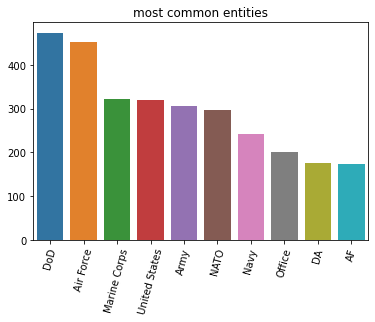

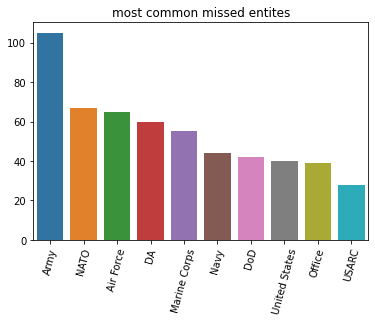

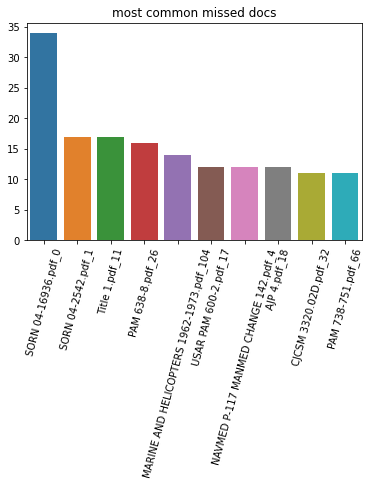

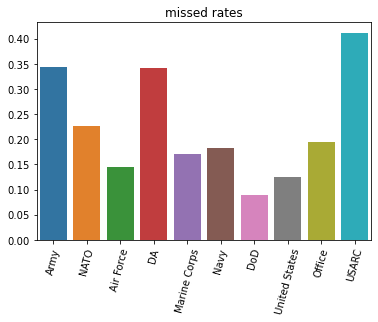

In [288]:
for index, x in enumerate(dictionaries):
    my_dict=dictionaries[x]
    plt.figure(index)
    keys = list(my_dict.keys())
    # get values in the same order as keys, and parse percentage values
    vals = [float(my_dict[k]) for k in keys]
    ax = sns.barplot(x=keys, y=vals)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 75)
    ax.set(title=x)